# MRI Dementia Classification - Load Pre-Saved Models
This model is used for MRI classification of dementia with 4 known stages (Non-Demented, Mild Demented, Moderate Demented and Very Mild Demented). Severe onset dementia is known as Alzheimer's Disease which will not be covered in this analysis. All data sourced from https://www.kaggle.com/datasets/matthewhema/mri-dementia-augmentation-no-data-leak

In [1]:
# Import Dependencies and Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import random
import splitfolders
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
# Load MRI Dataset
import kagglehub

# # Download original dataset that is unbalanced
# path = kagglehub.dataset_download("matthewhema/mri-dementia-augmentation-no-data-leak")

# Download augmented dataset that is balanced
path = kagglehub.dataset_download("uraninjo/augmented-alzheimer-mri-dataset")

print("Path to dataset files:", path)

Path to dataset files: /Users/ingridblankevoort/.cache/kagglehub/datasets/uraninjo/augmented-alzheimer-mri-dataset/versions/1


## Split images into train, test, val folders

In [3]:
# # Split the dataset into training, validation, and test sets
# splitfolders.ratio(path + '/AugmentedAlzheimerDataset', output="data_split_trainTestVal", seed=1337, ratio=(.7, .15, .15))

# # Show path to output folder
# print("Path to output folder:", os.path.abspath("data_split_trainTestVal"))

## Image Processing

Here we're leveraging a function called ImageDataGenerator() from the Tensor library to combine all of the operations of rescaling, setting our target size, batch size, etc to prep them into respective bins - Train, Test and Validation. 

In [3]:
# # Set local data paths for orginal kaggle dataset (matthewhema)
# train_dir = path + '/Train/Train'
# val_dir = path + '/Val/Val'
# test_dir = path + '/Test/Test'

# Set local data paths for augmented kaggle dataset (uraninjo)
train_dir = 'data_split_trainTestVal/train'
val_dir = 'data_split_trainTestVal/val'
test_dir = 'data_split_trainTestVal/test'

# Store ImageDataGenerator parameters in a dictionary
imageDataGenerator_params = {
    'rescale': 1./255,
    'rotation_range': 20,
    'width_shift_range': 0.2,
    'height_shift_range': 0.2,
    'shear_range': 0.2,
    'zoom_range': 0.2,
    'horizontal_flip': True,
    'fill_mode': 'nearest'   
}

In [4]:
# Image Generators Variables

# Resize all input images to 240x240
image_size = (240, 240)

#Number of images the model processes before updating weights
batch_size = 32

# Set the color space
color_mode = 'rgb'

# Class mode
class_mode = 'categorical'

# Define the class order
class_labels = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']

In [5]:
# Split the dataset into training, validation, and test sets
splitfolders.ratio(path + '/AugmentedAlzheimerDataset', output="data_split_trainTestVal", seed=1337, ratio=(.7, .15, .15))

# Show path to output folder
print("Path to output folder:", os.path.abspath("data_split_trainTestVal"))

Copying files: 0 files [00:00, ? files/s]

Copying files: 33984 files [00:07, 4395.78 files/s]

Path to output folder: /Users/ingridblankevoort/Library/CloudStorage/Dropbox/My Mac (Ingrids-MacBook-Pro.local)/Desktop/Group2_Project3_AI_Chatbot/data_split_trainTestVal


In [6]:
# Rescaling [0,1] for neural networks to process normalized values
train_datagen = ImageDataGenerator(imageDataGenerator_params)
val_datagen = ImageDataGenerator(imageDataGenerator_params)
test_datagen = ImageDataGenerator(imageDataGenerator_params)

# Create Generators for Train, Val and Test
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode=class_mode, 
    shuffle=False
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode=class_mode, 
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode=class_mode, 
    shuffle=False
)

Found 23788 images belonging to 4 classes.
Found 5097 images belonging to 4 classes.
Found 5099 images belonging to 4 classes.


### Visualize the data 

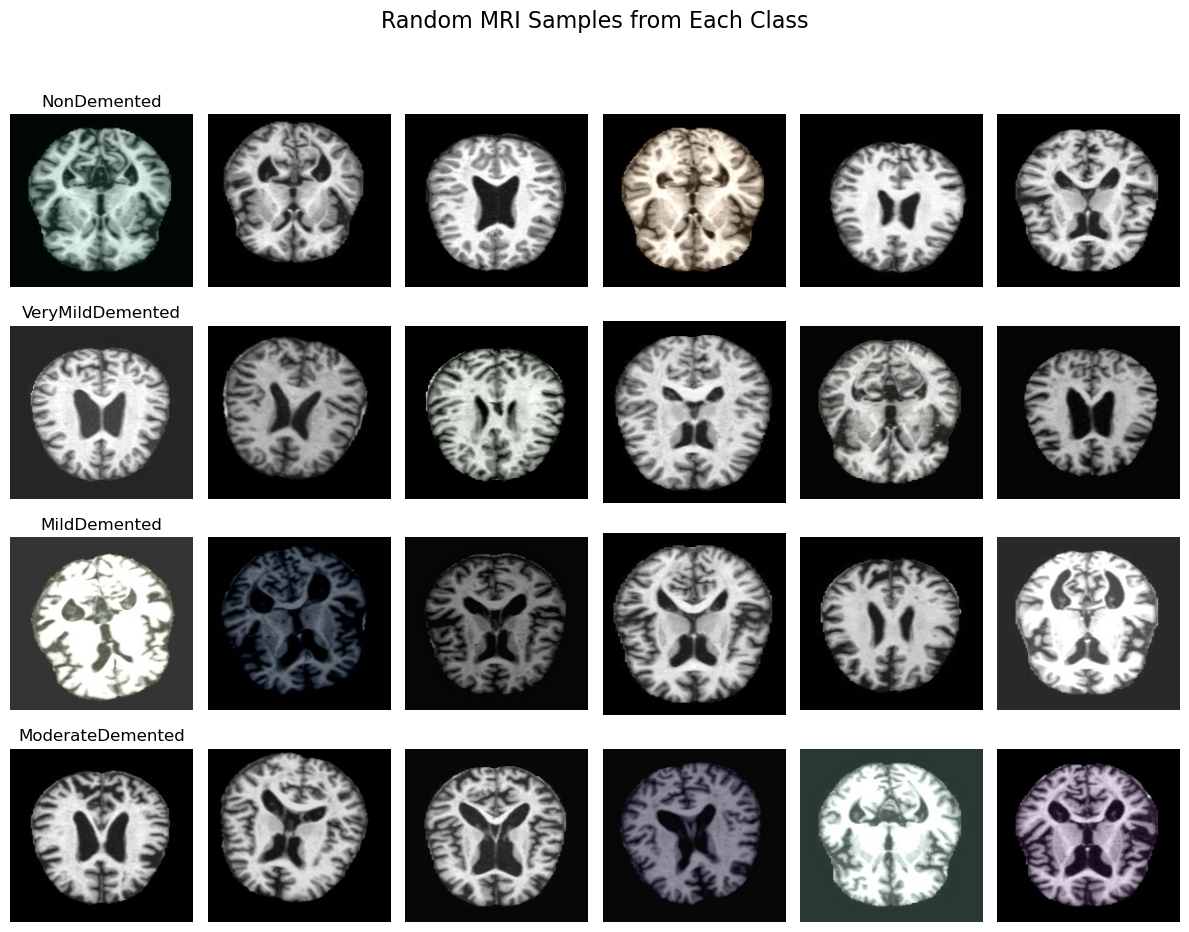

In [7]:
# Corresponding actual folder names in the dataset

# # Use this folder map for the original dataset
# folder_map = {
#     'Non Demented': 'Non Demented',
#     'Very MildDemented': 'Very MildDemented',
#     'Mild Demented': 'Mild Demented/Mild Demented Merge',
#     'Moderate Demented': 'Moderate Demented/Moderate Demented Merge'
# }

# Use this folder map for the augmented dataset
folder_map = {
    'NonDemented': 'NonDemented',
    'VeryMildDemented': 'VeryMildDemented',
    'MildDemented': 'MildDemented',
    'ModerateDemented': 'ModerateDemented'
}

# Update this to your dataset's base folder path
base_dir = 'data_split_trainTestVal/train'

# Set up subplots
fig, axes = plt.subplots(len(class_labels), 6, figsize=(12, 10))
if len(class_labels) == 1:
    axes = np.expand_dims(axes, axis=0)

fig.suptitle('Random MRI Samples from Each Class', fontsize=16)

for row_idx, label in enumerate(class_labels):
    folder_name = folder_map[label]
    class_path = os.path.join(base_dir, folder_name)

    if not os.path.exists(class_path):
        print(f"Directory not found for: {folder_name}")
        continue

    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    if len(image_files) == 0:
        print(f"No images found in folder: {folder_name}")
        continue

    # Safe sampling (with replacement if fewer than 6)
    sampled_files = random.choices(image_files, k=min(6, len(image_files)))

    for col_idx in range(6):
        ax = axes[row_idx, col_idx]
        ax.axis('off')

        if col_idx < len(sampled_files):
            img_path = os.path.join(class_path, sampled_files[col_idx])
            image = mpimg.imread(img_path)
            ax.imshow(image, cmap='gray')
            if col_idx == 0:
                ax.set_title(label)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [8]:
# Check the class indices for each generator
train_class_indices = train_generator.class_indices
val_class_indices = val_generator.class_indices
test_class_indices = test_generator.class_indices

# Print the class indices
print("Train Class indices:", train_class_indices)
print("Validation Class indices:", val_class_indices)
print("Test Class indices:", test_class_indices)

# Check color space
print(train_generator.image_shape)  # should be (224, 224, 3)

Train Class indices: {'MildDemented': 0, 'ModerateDemented': 1, 'NonDemented': 2, 'VeryMildDemented': 3}
Validation Class indices: {'MildDemented': 0, 'ModerateDemented': 1, 'NonDemented': 2, 'VeryMildDemented': 3}
Test Class indices: {'MildDemented': 0, 'ModerateDemented': 1, 'NonDemented': 2, 'VeryMildDemented': 3}
(240, 240, 3)


## Load the Model and History files

In [10]:
# Load the model
model = load_model('saved_models/dementia_cnn_sequential_model_V9.keras')

2025-05-13 18:19:52.248705: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-05-13 18:19:52.248797: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 48.00 GB
2025-05-13 18:19:52.248817: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 18.00 GB
I0000 00:00:1747181992.248834 1093652 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1747181992.248866 1093652 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [12]:
# Load the pickle file into history
import pickle

with open('saved_models/dementia_cnn_sequential_history_V9.pkl', 'rb') as f:
    history_dict = pickle.load(f)

class History:
    def __init__(self, history):
        self.history = history

history = History(history_dict)

### Run the Model on Test data

In [13]:
%%time
# Evaluation on Test Set
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc:.2f}")

# Predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

/opt/anaconda3/envs/dev/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/opt/anaconda3/envs/dev/lib/python3.12/site-packages/keras/src/legacy/preprocessing/image.py:1263: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
2025-05-13 18:20:03.938523: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7486 - loss: 89.6647
Test Accuracy: 0.44
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
CPU times: user 6.45 s, sys: 2.77 s, total: 9.22 s
Wall time: 9.11 s


### Analysis of Results

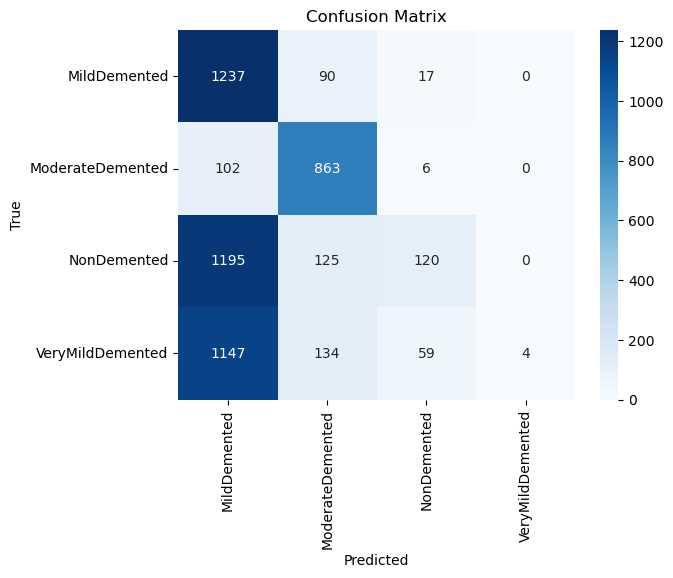

                  precision    recall  f1-score   support

    MildDemented       0.34      0.92      0.49      1344
ModerateDemented       0.71      0.89      0.79       971
     NonDemented       0.59      0.08      0.15      1440
VeryMildDemented       1.00      0.00      0.01      1344

        accuracy                           0.44      5099
       macro avg       0.66      0.47      0.36      5099
    weighted avg       0.66      0.44      0.32      5099



In [14]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices,
            yticklabels=test_generator.class_indices)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Get class labels in correct order
labels_sorted = sorted(test_generator.class_indices, key=test_generator.class_indices.get)

# Show classification report
print(classification_report(y_true, y_pred_classes, target_names=labels_sorted))

In [15]:
# Print the number of images in each class - non and very mild are weighing the dataset down. 
import collections
print(collections.Counter(test_generator.classes))

Counter({2: 1440, 0: 1344, 3: 1344, 1: 971})


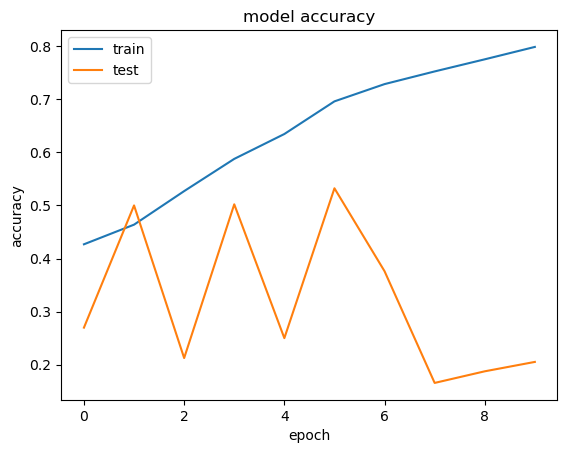

In [16]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

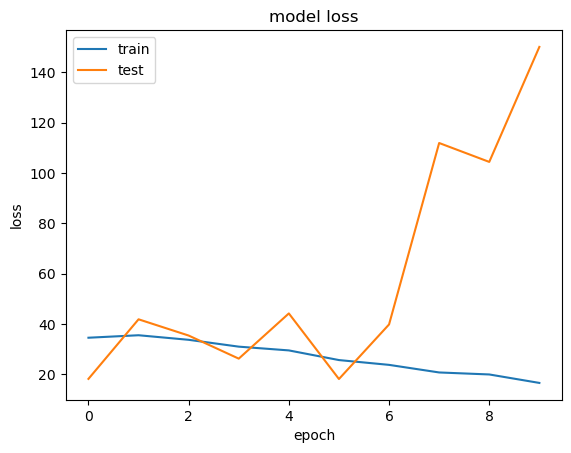

In [17]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Predict on a Single Image

In [18]:
def predict_single_image(image_path):
    # Load image and resize
    img = load_img(image_path, color_mode='rgb', target_size=(240, 240))

    # Convert to array 
    img_array = img_to_array(img)

    # Normalize and add batch dimension
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    preds = model.predict(img_array)
    predicted_index = np.argmax(preds)
    confidence = float(np.max(preds))

    # Update with your class labels
    predicted_label = class_labels[predicted_index]

    # Output
    print(f"Predicted class: {predicted_label}")
    print(f"Confidence: {confidence:.2f} ({confidence*100:.2f}%)")
    print("Softmax output:", preds)

    # Plot confidence for all classes
    plt.figure(figsize=(8, 4))
    plt.bar(class_labels, preds[0])
    plt.title("Prediction Confidence per Class")
    plt.ylabel("Probability")
    plt.ylim(0, 1)
    plt.show()

    return predicted_label, confidence, preds

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step
Predicted class: MildDemented
Confidence: 1.00 (100.00%)
Softmax output: [[0. 0. 1. 0.]]


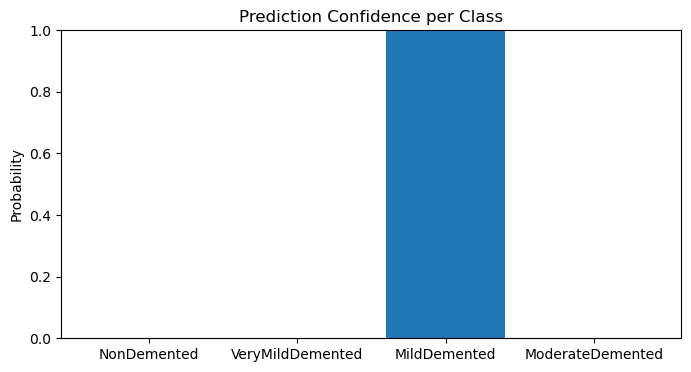

('MildDemented', 1.0, array([[0., 0., 1., 0.]], dtype=float32))

In [20]:
# Predict a single image
predict_single_image("saved_models/27 (40).jpg")